In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Reading data
all_xray_df = pd.read_csv('../data/archive/Data_Entry_2017.csv')
all_xray_df.drop(columns = 'Unnamed: 11', inplace = True)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [3]:
# Creating a new column with absolute path
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('..', 'data','archive', 'images*', '*', '*.png'))}
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,..\data\archive\images_001\images\00000001_000...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,..\data\archive\images_001\images\00000001_001...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,..\data\archive\images_001\images\00000001_002...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,..\data\archive\images_001\images\00000002_000...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,..\data\archive\images_001\images\00000003_000...


In [4]:
# Finding all unique labels
all_labels = []
for label in all_xray_df['Finding Labels']:
    temp_label_array = label.split('|')
    for t_label in temp_label_array:
        if t_label not in all_labels:
            all_labels.append(t_label)
all_labels

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'No Finding',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

In [5]:
# creating dictionary of list for each label
all_labels_dict = {x:list() for x in all_labels}
for label in all_xray_df['Finding Labels']:
    temp_label_array = label.split('|')
    for a_label in all_labels:
        if a_label in temp_label_array:
            all_labels_dict[a_label].append(1)
        elif a_label not in temp_label_array:
            all_labels_dict[a_label].append(0)
        else:
            print('Error: {}'.format(a_label))
        


In [6]:
# Adding the colums to dataframe
for col in all_labels_dict.keys():
    all_xray_df[col] = all_labels_dict[col]

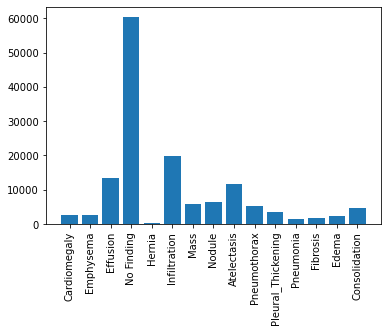

In [7]:
# Getting the occurences for each disease
no_of_ocurrences = dict(all_xray_df.iloc[:,[*range(12,27)]].sum(axis = 0))
plt.xticks(rotation=90)
_ = plt.bar(no_of_ocurrences.keys(),no_of_ocurrences.values())

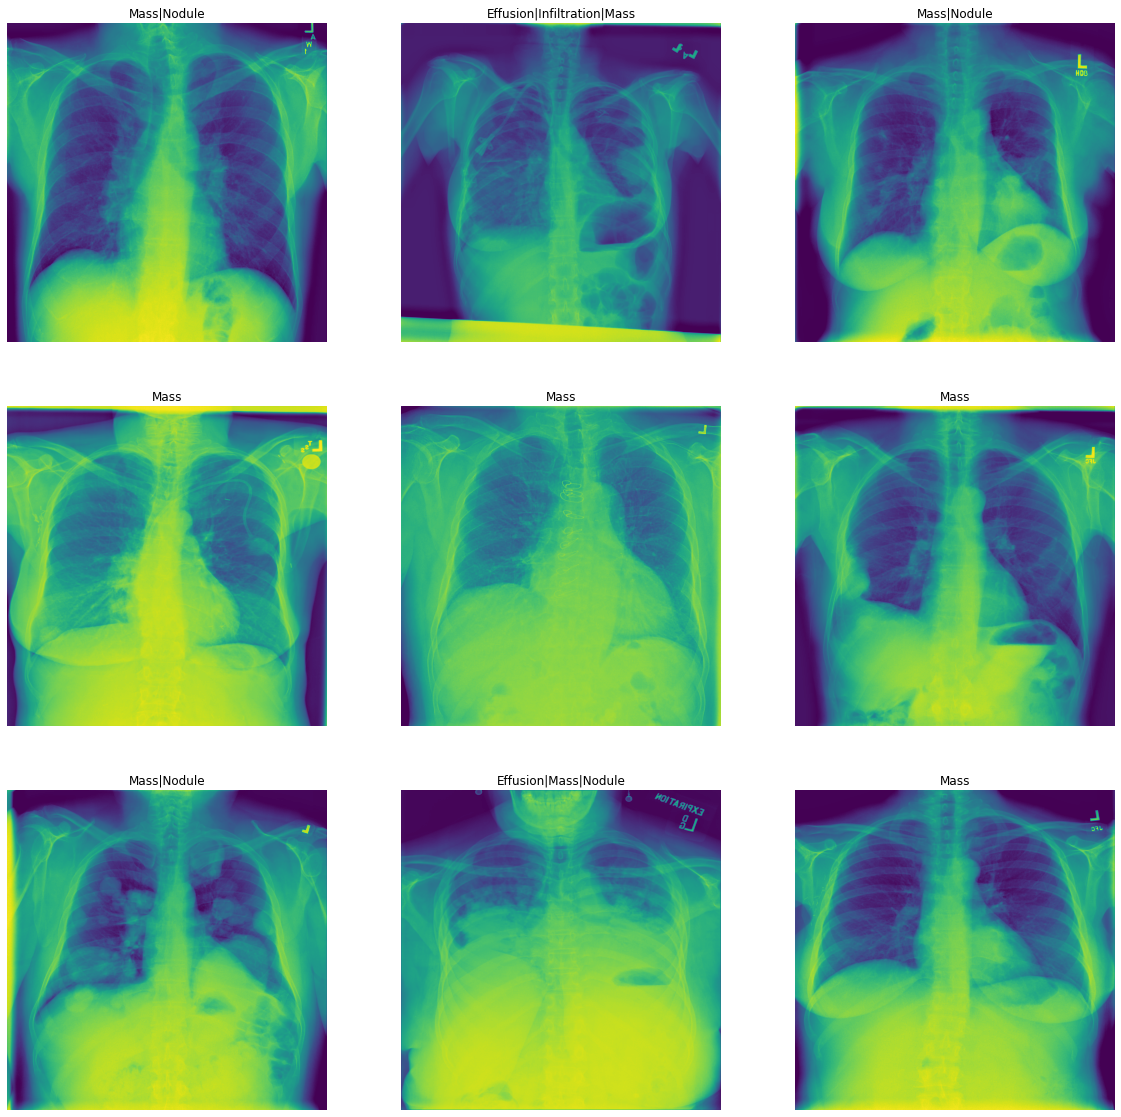

In [8]:
# Display some images
mask = all_xray_df['Mass'] == 1

masked_df = all_xray_df[mask].reset_index()
plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    random_number = np.random.randint(0,len(masked_df))
    plt.imshow(plt.imread(masked_df['path'][random_number]))
    plt.title(masked_df['Finding Labels'][random_number])
    plt.axis("off")

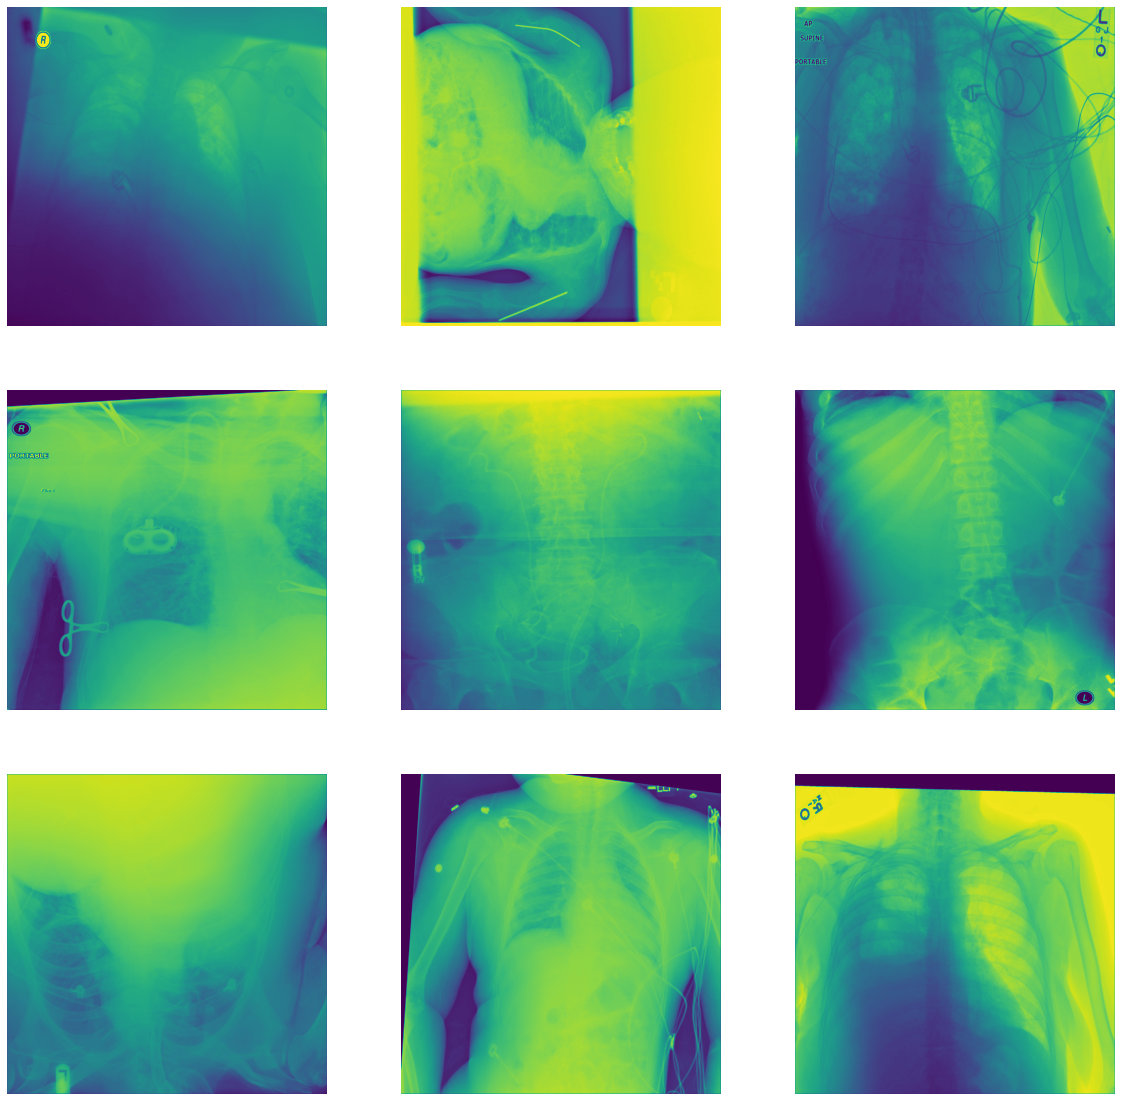

In [9]:
# Seeing Bad data
bad_df = pd.read_csv('../data/archive/cxr14_bad_labels.csv')
bad_path = [all_image_paths[x] for x in bad_df['Index']] 

plt.figure(figsize=(20, 20))
for i,path in zip(range(9),bad_path[0:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(path))
    plt.axis("off")


In [10]:
# Removing bad data
bad_mask = all_xray_df['Image Index'].isin(bad_df['Index'])
bad_index = all_xray_df[bad_mask].index
all_xray_df.drop(bad_index, inplace = True)

In [11]:
# Removing unwanted columns
drop_columns = ['Finding Labels','Follow-up #','Patient Age','Patient Gender','View Position','OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]']
all_xray_df.drop(columns = drop_columns, inplace  = True)

In [12]:
# Creating train test split
train_list = pd.read_csv('../data/archive/train_val_list.txt', header = None)
test_list = pd.read_csv('../data/archive/test_list.txt', header = None)

train_mask = all_xray_df['Image Index'].isin(train_list[0])
test_mask = all_xray_df['Image Index'].isin(test_list[0])

train_df = all_xray_df[train_mask].reset_index(drop = True)
test_df = all_xray_df[test_mask].reset_index(drop = True)

In [13]:
# Checking patient intersection between train and test set
train_ids = set(train_df['Patient ID'])
test_ids = set(test_df['Patient ID'])
overlap = train_ids.intersection(test_ids)
len(overlap)

0

In [14]:
# Creating validation split from training data
train_df, val_df = train_test_split(train_df, test_size = 0.5, random_state = 1998)
train_df.reset_index(drop = True, inplace = True)
val_df.reset_index(drop = True, inplace = True)

In [15]:
# Checking patient intersection between train and val set
train_ids = set(train_df['Patient ID'])
val_ids = set(val_df['Patient ID'])
overlap = list(train_ids.intersection(val_ids))
n_overlap = len(overlap)
n_overlap

9204

In [16]:
# Getting indices of overlapped patients
train_overlap_idxs = []
valid_overlap_idxs = []
for idx in range(n_overlap):
    train_overlap_idxs.extend(train_df.index[train_df['Patient ID'] == overlap[idx]].tolist())
    valid_overlap_idxs.extend(val_df.index[val_df['Patient ID'] == overlap[idx]].tolist())


In [17]:
# moving the ids from validation to train set
overlapping_val_df = val_df.iloc[valid_overlap_idxs,:]
val_df.drop(valid_overlap_idxs, inplace = True)
overlapping_val_df

,Image Index,Patient ID,path,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
35676,00000001_002.png,1,..\data\archive\images_001\images\00000001_002...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
22581,00000008_002.png,8,..\data\archive\images_001\images\00000008_002...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1632,00000011_002.png,11,..\data\archive\images_001\images\00000011_002...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3254,00000011_000.png,11,..\data\archive\images_001\images\00000011_000...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12912,00000011_004.png,11,..\data\archive\images_001\images\00000011_004...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42661,00030772_000.png,30772,..\data\archive\images_012\images\00030772_000...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3744,00030786_000.png,30786,..\data\archive\images_012\images\00030786_000...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9457,00030786_005.png,30786,..\data\archive\images_012\images\00030786_005...,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
17143,00030786_001.png,30786,..\data\archive\images_012\images\00030786_001...,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0


In [18]:
# combine overlapping val with train_set
train_df = train_df.append(overlapping_val_df)
train_df

,Image Index,Patient ID,path,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021269_001.png,21269,..\data\archive\images_010\images\00021269_001...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,00007064_002.png,7064,..\data\archive\images_004\images\00007064_002...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,00004746_023.png,4746,..\data\archive\images_003\images\00004746_023...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,00009357_000.png,9357,..\data\archive\images_005\images\00009357_000...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,00014224_002.png,14224,..\data\archive\images_007\images\00014224_002...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42661,00030772_000.png,30772,..\data\archive\images_012\images\00030772_000...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3744,00030786_000.png,30786,..\data\archive\images_012\images\00030786_000...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9457,00030786_005.png,30786,..\data\archive\images_012\images\00030786_005...,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
17143,00030786_001.png,30786,..\data\archive\images_012\images\00030786_001...,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0


In [19]:
# Checking patient intersection between train and val set
train_ids = set(train_df['Patient ID'])
val_ids = set(val_df['Patient ID'])
overlap = list(train_ids.intersection(val_ids))
n_overlap = len(overlap)
n_overlap

0

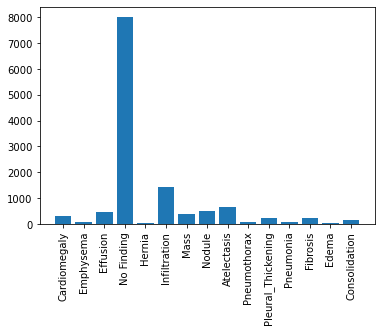

In [20]:
# Distribution of examples in validation
no_of_ocurrences = dict(val_df.iloc[:,[*range(3,18)]].sum(axis = 0))
plt.xticks(rotation=90)
_ = plt.bar(no_of_ocurrences.keys(),no_of_ocurrences.values())

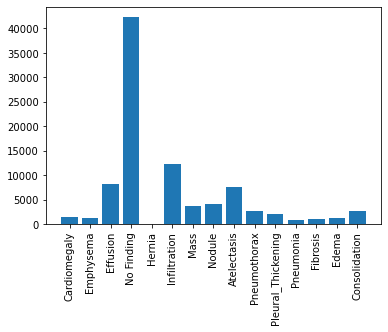

In [21]:
# Distribution of examples in train
no_of_ocurrences = dict(train_df.iloc[:,[*range(3,18)]].sum(axis = 0))
plt.xticks(rotation=90)
_ = plt.bar(no_of_ocurrences.keys(),no_of_ocurrences.values())

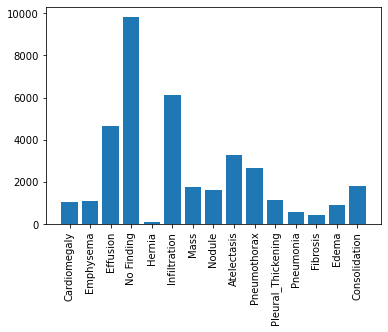

In [22]:
# Distribution of examples in test
no_of_ocurrences = dict(test_df.iloc[:,[*range(3,18)]].sum(axis = 0))
plt.xticks(rotation=90)
_ = plt.bar(no_of_ocurrences.keys(),no_of_ocurrences.values())

In [25]:
# Creating Final CSV files for train, test and val
train_df.to_csv('../data/archive/train_df.csv',index = False)
val_df.to_csv('../data/archive/val_df.csv', index = False)
test_df.to_csv('../data/archive/test_df.csv', index = False)

In [26]:
train_df

,Image Index,Patient ID,path,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021269_001.png,21269,..\data\archive\images_010\images\00021269_001...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,00007064_002.png,7064,..\data\archive\images_004\images\00007064_002...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,00004746_023.png,4746,..\data\archive\images_003\images\00004746_023...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,00009357_000.png,9357,..\data\archive\images_005\images\00009357_000...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,00014224_002.png,14224,..\data\archive\images_007\images\00014224_002...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42661,00030772_000.png,30772,..\data\archive\images_012\images\00030772_000...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3744,00030786_000.png,30786,..\data\archive\images_012\images\00030786_000...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9457,00030786_005.png,30786,..\data\archive\images_012\images\00030786_005...,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
17143,00030786_001.png,30786,..\data\archive\images_012\images\00030786_001...,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
